# Submit Predictions

This notebook shows how to prepare a submission of your model's predictions on the test data for the computation.

In [47]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from pathlib import Path
from natsort import natsorted
import numpy as np
from safetensors.torch import load_model
import torch 
import pandas as pd

from utils import hvatnet
from utils.creating_dataset import LEFT_TO_RIGHT_HAND

import matplotlib.pyplot as plt


## Load pre-trained model

This code loads the pre-trained baseline model - might be different for your model.

In [53]:
dataset_name = 'BCI_kaggle_1024'
model_str = 'BCI_kaggle_1024'
run_tag = 'longer'
models_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/pbt-bci-kaggle/{dataset_name}"
model_dest = f"{models_dest}/{run_tag}"

In [55]:
sess_name='1024'
data_path = os.path.join(model_dest,'best_model','',f'lfads_output_{sess_name}.h5')
with h5py.File(data_path) as f:
    print(f.keys())
    # Merge train and valid data for factors and rates
    factors = f["valid_factors"][:]
    behavior = f["valid_output_behavior_params"][:]
    controls = f['valid_gen_inputs'][:]
    ic = f['valid_gen_init'][:]
    control_mean = f['valid_co_means'][:]
    control_stds = f['valid_co_stds'][:]

    train_factors = f["train_factors"][:]
    train_controls = f['train_gen_inputs'][:]
    train_ic = f['train_gen_init'][:]

<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_output_behavior_params', 'train_output_params', 'train_recon_data', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_output_behavior_params', 'valid_output_params', 'valid_recon_data']>


In [56]:
# load dataset from h5
data_path = Path(r"/disk/scratch2/nkudryas/BAND-torch/datasets/BCI_train_1024.h5")
import h5py
with h5py.File(data_path, 'r') as f:
    X = f['valid_encod_data'][:]
    Y = f['valid_behavior'][:]

In [57]:
behavior.shape

(396, 128, 20)

In [58]:
MSE_mine = 0
for t in range(X.shape[0]):
    MSE_mine += np.mean((behavior[t] - Y[t])**2)
# print(86/MSE*0.1559)
print(MSE_mine)

41.33340882137418


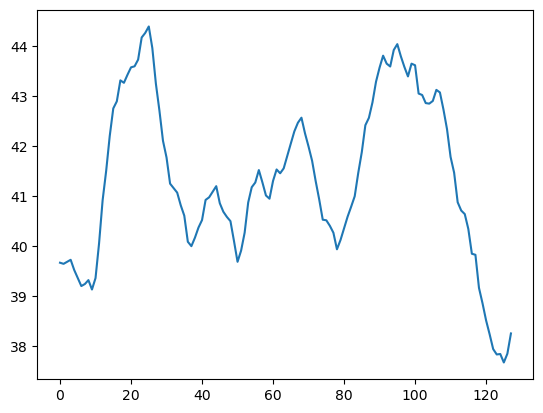

In [60]:
MSE_time = np.zeros([128])
for t in range(X.shape[0]):
    MSE_time += np.mean((behavior[t] - Y[t])**2,axis=-1)
plt.plot(MSE_time)

### Save `submission.cvs` file

This code shows how the data was prepare and downsampled during inference. Make sure that your data is processed similarly!

In [61]:
DATA_PATH = Path(r"/disk/scratch_fast/nkudryas/dataset_v2_blocks")
test_data_name = 'fedya_tropin_standart_elbow_left'  # shoould match `test_dataset_list` used to train the model


data_folder = DATA_PATH / "amputant" / "left" / test_data_name / "preproc_angles" / "submit"
all_paths = natsorted(data_folder.glob('*.npz'))
print(f'Found {len(all_paths)} samples in {data_folder}')


Found 72 samples in /disk/scratch_fast/nkudryas/dataset_v2_blocks/amputant/left/fedya_tropin_standart_elbow_left/preproc_angles/submit


In [91]:
sess_name='1024'
data_path = os.path.join(model_dest,'best_model','',f'lfads_output_{sess_name}.h5')
with h5py.File(data_path) as f:
    print(f.keys())
    # Merge train and valid data for factors and rates
    factors = f["valid_factors"][:]
    behavior_submit = f["valid_output_behavior_params"][:]
    controls = f['valid_gen_inputs'][:]
    ic = f['valid_gen_init'][:]
    control_mean = f['valid_co_means'][:]
    control_stds = f['valid_co_stds'][:]

<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_output_behavior_params', 'train_output_params', 'train_recon_data', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_output_behavior_params', 'valid_output_params', 'valid_recon_data']>


In [92]:
pred_list = []

# loop over each trial
batches = []
all_batch_starts = []
sample_ids = []
gt_lens = []
for i, p in enumerate(all_paths):
    # get EMG data 
    sample = np.load(p)
    myo = sample['data_myo']
    myo = myo[:, LEFT_TO_RIGHT_HAND]

    gt_len = myo[::8].shape[0]
    gt_lens.append(gt_len)

    # padding
    target_length = (myo.shape[0] + 511) // 512 * 512
    padded_myo = np.pad(myo, ((0, target_length - myo.shape[0]), (0, 0)), mode='constant', constant_values=0)

    batch_starts = np.arange(0,padded_myo.shape[0],128)
    where_gets_beyond = np.where(batch_starts+1024 >= padded_myo.shape[0])[0]
    batch_starts = batch_starts[:where_gets_beyond[0]+1]

    if (batch_starts[-1]+1024) > padded_myo.shape[0]:
        batch_starts[-1] = padded_myo.shape[0] - 1024
    if len(batch_starts) > 1:
        assert batch_starts[-2] < batch_starts[-1] 
        assert batch_starts[-2] + 1024 > batch_starts[-1] 
    assert batch_starts[-1] + 1024 == padded_myo.shape[0]

    print(batch_starts, myo.shape)

    for bs in batch_starts:
        batches.append(padded_myo[bs:bs+1024])
        all_batch_starts.append(bs)
        sample_ids.append(i+1)

    # batch_starts = np.arange(0,myo.shape[0]-128,128)

    # if (batch_starts[-1]+256) > myo.shape[0]:
    #     batch_starts[-1] = myo.shape[0] - 256
    # assert batch_starts[-2] < batch_starts[-1] 
    # assert batch_starts[-1] + 256 == myo.shape[0]

    # for bs in batch_starts:
    #     batches.append(myo[bs:bs+256])
    #     all_batch_starts.append(bs)
    #     sample_ids.append(i+1)

batches = np.array(batches)
all_batch_starts = np.array(all_batch_starts).flatten()
sample_ids = np.array(sample_ids).flatten()

X_test = np.array(batches) # batches x time x channels
Y_test = np.zeros((X_test.shape[0],X_test.shape[1]//8,Y.shape[-1]))

print(X_test.shape, Y_test.shape)

[   0  128  256  384  512  640  768  896 1024 1152 1280 1408 1536 1664
 1792 1920 2048 2176 2304 2432 2560 2688 2816 2944 3072] (3721, 8)
[   0  128  256  384  512  640  768  896 1024 1152 1280 1408 1536 1664
 1792 1920 2048 2176 2304 2432 2560 2688 2816 2944 3072] (3725, 8)
[   0  128  256  384  512  640  768  896 1024 1152 1280 1408 1536 1664
 1792 1920 2048 2176 2304 2432 2560 2688 2816 2944 3072] (3724, 8)
[   0  128  256  384  512  640  768  896 1024 1152 1280 1408 1536 1664
 1792 1920 2048 2176 2304 2432 2560 2688 2816 2944 3072] (3724, 8)
[   0  128  256  384  512  640  768  896 1024 1152 1280 1408 1536 1664
 1792 1920 2048 2176 2304 2432 2560 2688 2816 2944 3072] (3729, 8)
[   0  128  256  384  512  640  768  896 1024 1152 1280 1408 1536 1664
 1792 1920 2048 2176 2304 2432 2560 2688 2816 2944 3072] (3726, 8)
[   0  128  256  384  512  640  768  896 1024 1152 1280 1408 1536 1664
 1792 1920 2048 2176 2304 2432 2560 2688 2816 2944 3072] (3724, 8)
[   0  128  256  384  512  640  76

In [93]:
# load predictions from df.to_csv('submit_file.csv', index=False)
df = pd.read_csv('submit_file.csv')
df

,sample_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,1,0.224688,-0.032974,0.343201,0.090468,0.232571,0.002192,0.378467,0.053292,0.273059,...,0.471837,0.262436,0.269101,0.013499,0.314245,0.177546,0.120567,-0.025374,0.390368,-0.077249
1,2,0.228221,-0.018129,0.328120,0.069635,0.237205,0.007883,0.418534,0.056629,0.301994,...,0.446129,0.234545,0.289485,0.012855,0.303110,0.195418,0.149258,-0.056385,0.368347,-0.107292
2,3,0.263330,-0.015492,0.296143,0.057059,0.268076,0.011281,0.336451,0.022698,0.324125,...,0.407882,0.214376,0.318359,0.010800,0.298510,0.194212,0.130489,-0.044943,0.343194,-0.117974
3,4,0.245696,-0.022762,0.313045,0.083402,0.296736,0.017667,0.351410,0.045054,0.328780,...,0.360658,0.217464,0.302074,0.007850,0.339354,0.216761,0.110535,-0.028326,0.366834,-0.112463
4,5,0.279694,-0.030697,0.294064,0.062555,0.308046,0.015644,0.392284,0.049894,0.326741,...,0.396558,0.218927,0.321763,0.009463,0.344875,0.201123,0.115177,-0.033454,0.394594,-0.107942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26824,26825,0.100371,-0.084686,0.488351,0.151842,-0.407159,-0.016745,1.448870,0.645073,-0.561438,...,1.629204,0.846105,0.001536,0.014757,0.533739,0.185548,0.174647,-0.147438,0.273809,-0.100778
26825,26826,0.107106,-0.083759,0.517394,0.158900,-0.385104,-0.011874,1.425296,0.627536,-0.535505,...,1.617995,0.828026,0.034458,0.006830,0.542168,0.207952,0.196639,-0.148877,0.266726,-0.093854
26826,26827,0.071811,-0.076179,0.527914,0.153560,-0.349921,-0.006264,1.271305,0.544794,-0.522018,...,1.638919,0.843450,0.003974,0.002232,0.584926,0.257998,0.169369,-0.117713,0.269341,-0.092909
26827,26828,0.051900,-0.053413,0.550750,0.176463,-0.318497,-0.008110,1.156332,0.476595,-0.537968,...,1.627341,0.829138,-0.045490,0.020426,0.626249,0.275561,0.133875,-0.094280,0.287146,-0.065336


(513, 20)


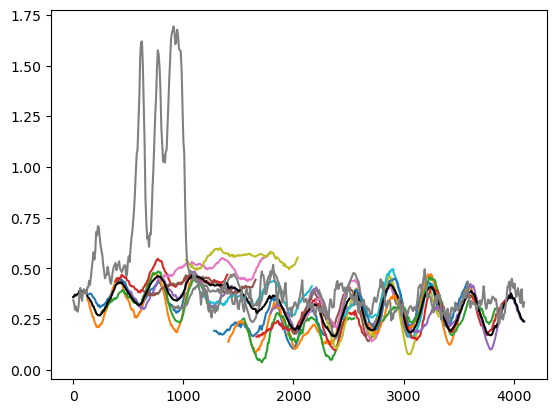

In [94]:
def merge(batch_starts,behaviors):
    target_length = 1+(batch_starts[-1] + 1024)//8
    beh_pred = np.ones((len(batch_starts),target_length,behaviors.shape[-1]))*np.nan
    W = np.zeros((len(batch_starts),target_length))
    batch_starts[-1] += 8 # temp fix
    for i,bs in enumerate(batch_starts):
        beh_pred[i,bs//8:(bs+1024)//8] = behaviors[i]
        W[i,bs//8:(bs+1024)//8] = 1-0.5*np.abs(np.arange(128)-64)/64

    check_nanmean = np.nanmean(beh_pred,axis=0)

    final_beh_pred = np.nansum(beh_pred * W[:,:,np.newaxis],axis=0)/np.nansum(W[:,:,np.newaxis],axis=0)

    return final_beh_pred

component = 2
bb = np.arange(behavior_submit.shape[0])[sample_ids==1]
baseline_pred = np.array(df[f'{component}'])
for b in bb:
    time = all_batch_starts[b] + np.arange(0,1024,8)
    plt.plot(time,behavior_submit[b,:,component])
beh_pred = merge(all_batch_starts[bb],behavior_submit[bb])
plt.plot(np.arange(beh_pred.shape[0])*8,beh_pred[:,component],c='k')
plt.plot(np.arange(beh_pred.shape[0])*8,baseline_pred[:len(beh_pred)],c='grey')
print(beh_pred.shape)

In [95]:
all_beh_preds = []
for sample_id in range(1,np.max(sample_ids)+1):
    bb = np.arange(behavior_submit.shape[0])[sample_ids==sample_id]
    beh_pred = merge(all_batch_starts[bb],behavior_submit[bb])[:gt_lens[sample_id-1]]
    # assert beh_pred.shape[0] == gt_lens[sample_id-1], (beh_pred.shape[0],gt_lens[sample_id-1])
    all_beh_preds.append(beh_pred)

my_pred_cat = np.concatenate(all_beh_preds, axis=0)
print(my_pred_cat.shape)
my_df = pd.DataFrame(my_pred_cat)
my_df.head()

(26829, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.168408,-0.039749,0.359096,0.049046,0.074936,-0.034704,0.564794,0.138314,0.059450,0.007847,0.682648,0.364310,0.134553,0.032293,0.479681,0.194753,0.046308,-0.016583,0.381976,-0.023490
1,0.163000,-0.035830,0.363578,0.057302,0.065786,-0.010755,0.569953,0.152731,0.051587,-0.005766,0.689260,0.370365,0.128491,0.025183,0.480950,0.195221,0.042312,-0.014519,0.387185,-0.015737
2,0.158331,-0.027751,0.370220,0.058677,0.061983,-0.001820,0.576993,0.142865,0.044204,0.004175,0.702999,0.372463,0.124429,0.038513,0.490866,0.198774,0.039901,-0.020662,0.389836,-0.012664
3,0.154009,-0.026946,0.366876,0.059051,0.058344,-0.048280,0.585936,0.152827,0.035299,0.017775,0.715066,0.382767,0.110223,0.037247,0.501271,0.206659,0.035749,-0.018736,0.394368,-0.005150
4,0.154079,-0.048861,0.371000,0.059455,0.051308,-0.037220,0.592193,0.150417,0.026322,0.007176,0.733329,0.390780,0.106835,0.014774,0.508394,0.206216,0.033206,-0.018356,0.395659,-0.000903


In [96]:
my_df.insert(0, "sample_id", range(1, 1 + len(my_df)))
my_df.to_csv('band_1024_4overlap_submit_file.csv', index=False)
my_df.shape

(26829, 21)

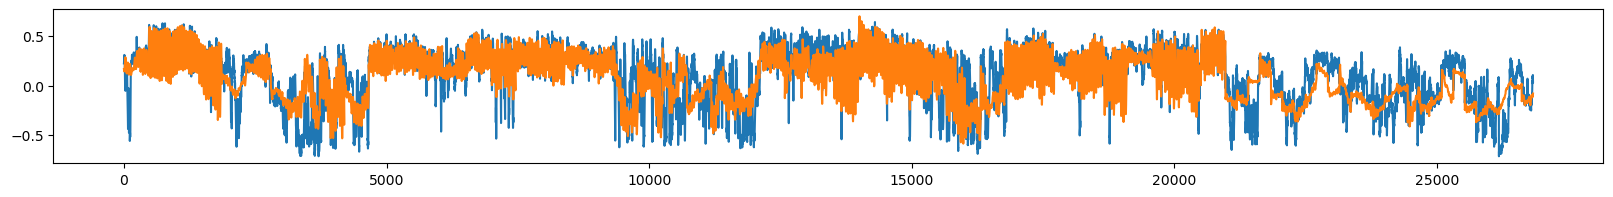

In [97]:
# plot df['0'] vs my_df['0']
plt.figure(figsize=(20,2))
plt.plot(df['0'][:])
plt.plot(my_df[0][:])

In [ ]:
# def merge(batch_starts,behaviors):
#     target_length = 1+(batch_starts[-1] + 256)//8
#     beh_pred = np.ones((len(batch_starts),target_length,behaviors.shape[-1]))*np.nan
#     W = np.zeros((len(batch_starts),target_length))
#     batch_starts[-1] += 8 # temp fix
#     for i,bs in enumerate(batch_starts):
#         beh_pred[i,bs//8:(bs+256)//8] = behaviors[i]
#         W[i,bs//8:(bs+256)//8] = 1-0.5*np.abs(np.arange(32)-16)/16
#         # extrapolate 16 bins before and after with const
#         if bs > 0:
#             beh_pred[i,-16+bs//8:bs//8] = behaviors[i,0]
#             W[i,-16+bs//8:bs//8] = np.arange(16)/16/2 # from 0 to 0.5
#         if (bs+256)//8+16 < target_length:
#             beh_pred[i,(bs+256)//8:(bs+256)//8+16] = behaviors[i,-1]
#             W[i,(bs+256)//8:(bs+256)//8+16] = 0.5-np.arange(16)/16/2 # from 0.5 to 0

#     check_nanmean = np.nanmean(beh_pred,axis=0)

#     final_beh_pred = np.nansum(beh_pred * W[:,:,np.newaxis]**2,axis=0)/np.nansum(W[:,:,np.newaxis]**2,axis=0)

#     return final_beh_pred